In [1]:
from data_loader import load_latest_iteration, load_all_files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import render_particles
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_soft = load_latest_iteration(
    f"../code/cpp/build/src/vtk_output_soft/data")

In [3]:
simulation_soft_all = load_all_files(
    f"../code/cpp/build/src/vtk_output_soft/data", "simulation")

In [4]:
lamdba_soft = data_soft["parameters"]["LAMBDA"][0]

In [5]:
particles = data_soft["particles"]

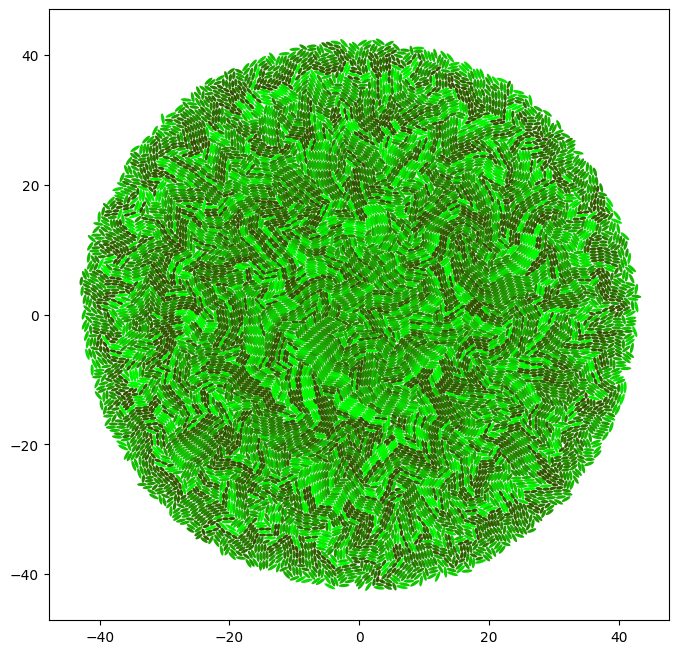

In [6]:
fig, ax = render_particles.draw_particles(particles)

In [7]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree
import numpy as np


def build_cell_graph(cells, distance_threshold=1.0, orientation_threshold=0.03):
    """
    Build a graph of cells where edges represent contact + orientation similarity.

    Parameters
    ----------
    cells : pd.DataFrame
        Columns: ['x', 'y', 'orientation_angle'] (0..pi)
    distance_threshold : float
        Max distance for edge
    orientation_threshold : float
        Max relative orientation difference (fraction of pi)

    Returns
    -------
    G : networkx.Graph
        Graph with nodes as cells and edges as contacts
    """
    positions = cells[['x', 'y']].values
    angles = cells['orientation_angle'].values

    tree = cKDTree(positions)
    neighbors = tree.query_pairs(r=distance_threshold)

    G = nx.Graph()
    G.add_nodes_from(range(len(cells)))

    for i, j in neighbors:
        angle_diff = abs(angles[i] - angles[j])
        angle_diff = min(angle_diff, np.pi - angle_diff)
        if angle_diff < orientation_threshold * np.pi:
            G.add_edge(i, j)

    return G, positions


def render_graph_hsv(G, positions, data, clusters=None):
    pos_dict = {i: (x, y) for i, (x, y) in enumerate(positions)}
    plt.figure(figsize=(10, 10))

    if clusters is None:
        nx.draw(G, pos=pos_dict, node_size=10, node_color='skyblue',
                edge_color='gray', with_labels=False)
    else:
        # Compute average angle for each cluster
        cluster_angles = []
        cluster_color_dict = {}
        for cluster in clusters:
            angles = data.iloc[list(cluster)]['orientation_angle'].values
            mean_angle = np.mean(angles)
            cluster_angles.append(mean_angle)

        # Map mean angles to HSV hue (0..1)
        cluster_hues = np.array(cluster_angles) / np.pi  # 0..1 range

        # Assign color per node based on cluster hue
        node_colors = np.zeros((len(data), 3))
        for idx, cluster in enumerate(clusters):
            hue = cluster_hues[idx]

            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # Full saturation, value
            for node in cluster:
                cluster_color_dict[node] = rgb
                node_colors[node] = rgb

        nx.draw(G, pos=pos_dict, node_size=10, node_color=node_colors,
                edge_color='gray', with_labels=False)

        #  create new dictionary with cluster colors

    plt.gca().set_aspect('equal')
    plt.show()

    if clusters is not None:
        return cluster_color_dict

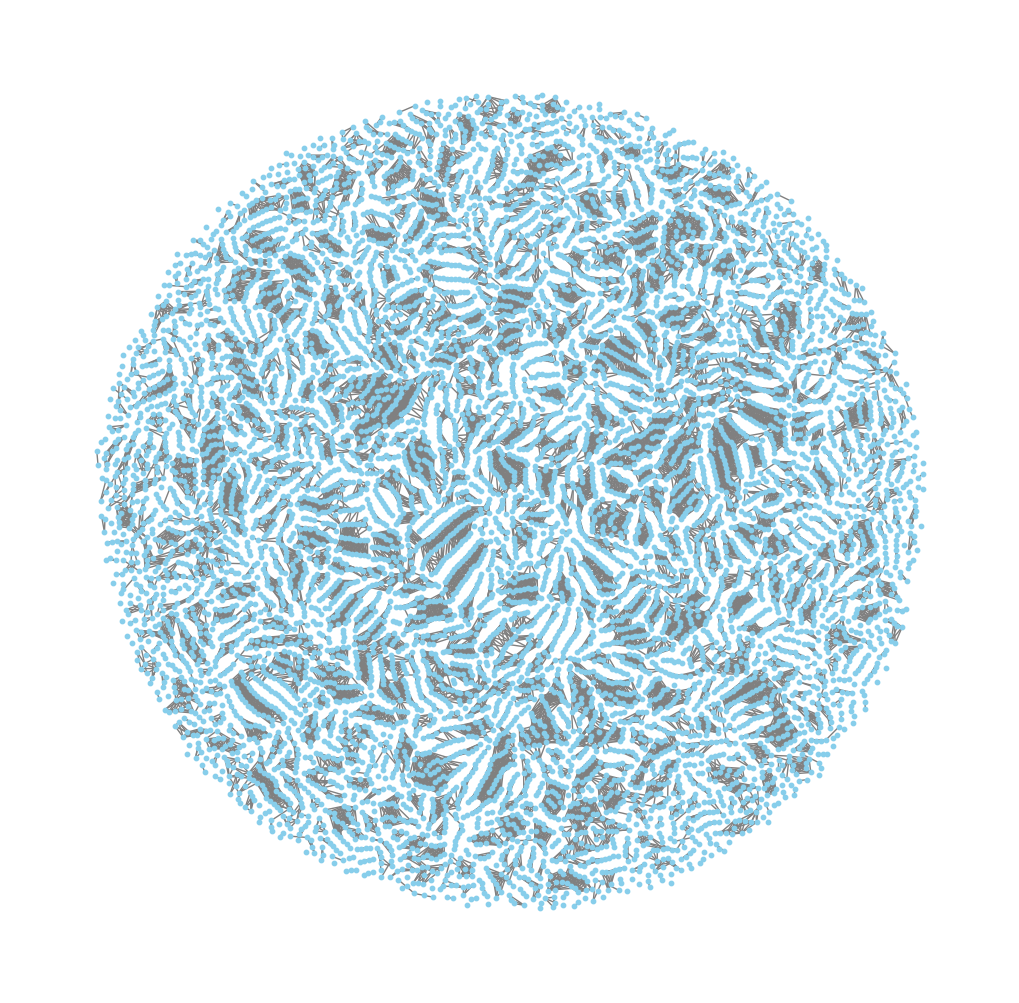

In [47]:
G, positions = build_cell_graph(
    particles, distance_threshold=2.2, orientation_threshold=0.03)

# Render graph
render_graph_hsv(G, positions, particles)

In [37]:
clusters = [list(c) for c in nx.connected_components(G)]
len(clusters)

1030

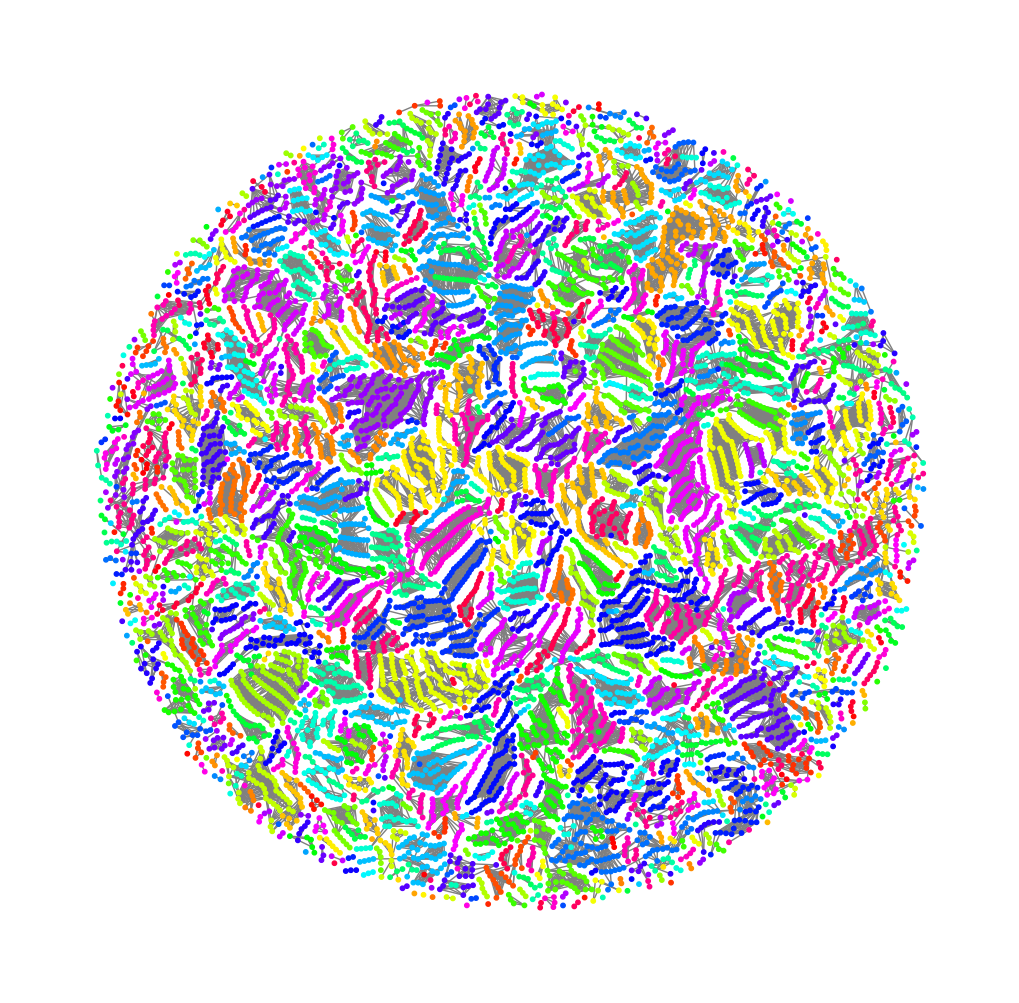

In [38]:
colors = render_graph_hsv(G, positions, particles, clusters=clusters)

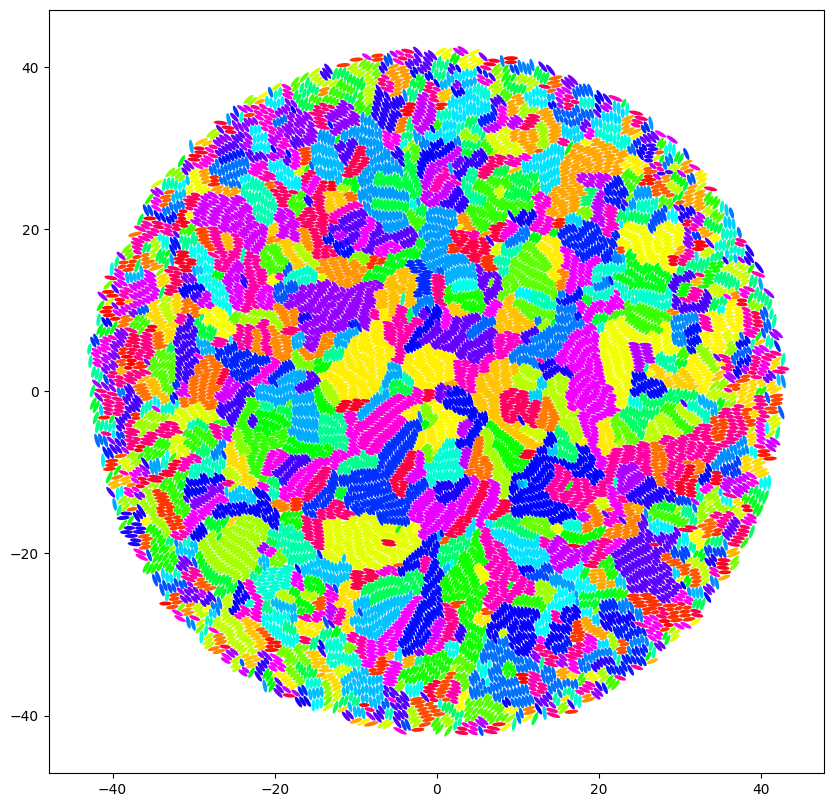

In [39]:
from render_particles import draw_particles_cluster


# Draw particles colored by cluster
fig, ax = draw_particles_cluster(particles,  colors)

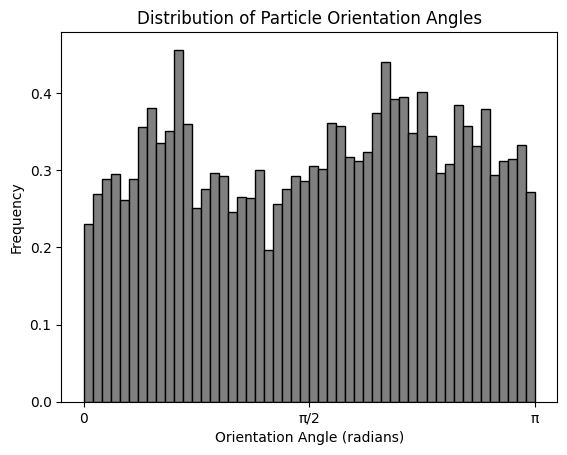

In [40]:
particles["orientation_angle"].plot.hist(bins=50,
                                         color='gray', edgecolor='black', density=True)
plt.xlabel("Orientation Angle (radians)")
plt.ylabel("Frequency")
plt.title("Distribution of Particle Orientation Angles")

# put 0 pi/2 and pi as x axis ticks
plt.xticks([0, np.pi/2, np.pi], ['0', 'π/2', 'π'])

plt.show()

In [41]:
def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2

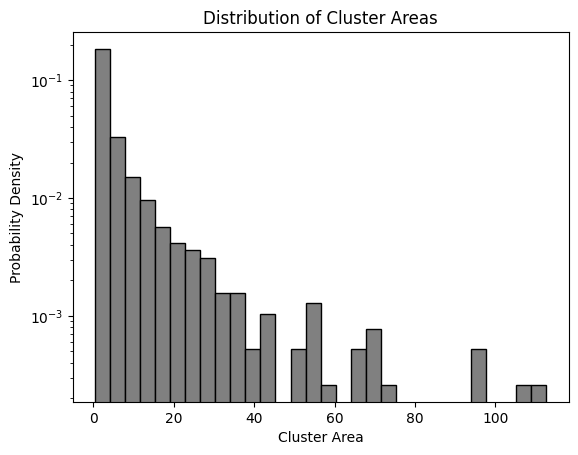

In [46]:
# determine average length per cluster
cluster_areas = []
for cluster in clusters:
    cluster_lengths = particles.iloc[cluster]['lengths_x']
    cluster_areas.append(sum(spherocylinder_area(l) for l in cluster_lengths))


cluster_series = pd.Series(cluster_areas)

# plot probability distribution of cluster areas
plt.hist(cluster_areas, bins=30, color='gray', edgecolor='black', density=True)
plt.xlabel("Cluster Area")
plt.ylabel("Probability Density")
plt.title("Distribution of Cluster Areas")
plt.yscale('log')

In [43]:
def Pa(A, A_star):
    return 0.1*np.exp(-A / A_star)

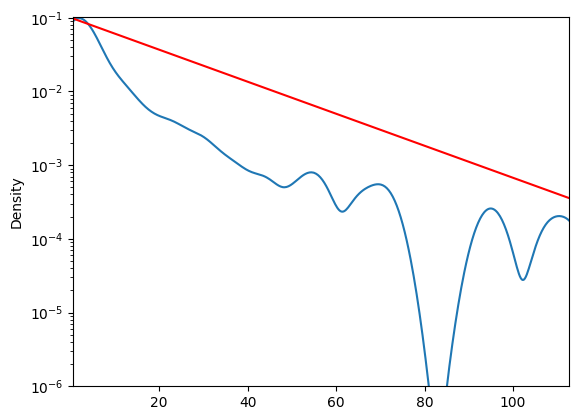

In [45]:
x = np.linspace(cluster_series.min(), cluster_series.max(), 100)

cluster_series.plot.kde()
plt.plot(x, Pa(x, 20.0), label='A* = 20.0', color='red')

y1 = Pa(x, 54.3)

plt.xlim(cluster_series.min(), cluster_series.max())
plt.ylim(1e-6, None)

# log scale x axis
plt.yscale('log')